# Lab3 - Mushroom Classification
Author: *YOUR NAME HERE*


In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the same workflow as in Lab2: Split data into training and test set. Use the training portion to find the best model using grid search and cross-validation. Evaluate the *winner* on the test set.

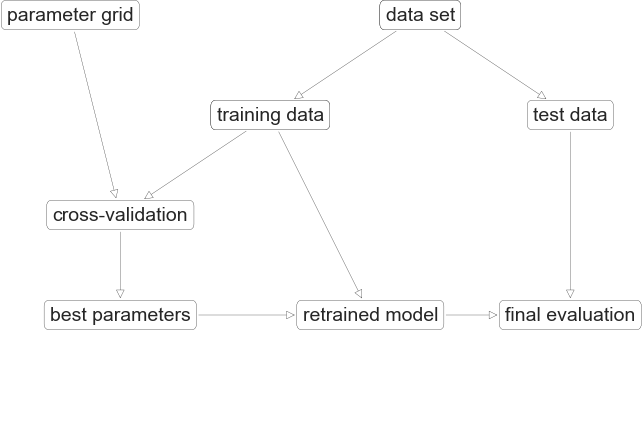

In [191]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [193]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    scores = cross_validate(model, X, y, cv=cv, scoring = scoring, 
                             return_train_score = True)
    a = ''
    for label in ['train_score', 'test_score']:
        a=a+('{} = {: .3f}     '.format( label,scores[label].mean()))
    return a
    
    
    
     #TODO: implement function body
    

In [195]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    scores = grid_search.cv_results_
    
    
    gs = grid_search.best_params_
    print('Best parameters = {}'.format(gs))
    print('Train score {:.3f}'.format(scores['mean_train_score'][grid_search.best_index_]))
    print('Validation score {:.3f}'.format(scores['mean_test_score'][grid_search.best_index_]))
    
    
     #TODO: implement function body
    

In [197]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [199]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, xticklabels = labels, yticklabels = labels, annot=True, fmt='.3g')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
   
    
    #TODO: implement function body
    
   

## 1. Load data
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html

### 1.1 Prepare a pandas dataframe of all data

Load the mushroom data set into a `DataFrame` variable `data`. Pass `return_dataset = True` to the loader to get a Dataset object. Calling the `to_dataframe()` method produces a `DataFrame`.

Print `data.head()` and `data.info()`.


In [203]:
# TODO: add data loading code
from yellowbrick.datasets import load_mushroom
data = load_mushroom(return_dataset=True).to_dataframe()
print(data.head())
print(data.info())


      target   shape surface   color
0     edible  convex  smooth  yellow
1     edible    bell  smooth   white
2  poisonous  convex   scaly   white
3     edible  convex  smooth    gray
4     edible  convex   scaly  yellow
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   8123 non-null   object
 1   shape    8123 non-null   object
 2   surface  8123 non-null   object
 3   color    8123 non-null   object
dtypes: object(4)
memory usage: 254.0+ KB
None


### *Question 1:* What is the column name of the classification target variable and what are the two class names?

*Target variable = target*

*Class names = edible , poisonous*

### 1.2 Prepare the feature matrix and target vector

Load the mushroom data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [205]:
# TODO: add data loading code

X, y = load_mushroom()
print(X.shape, type(X))
print(y.shape, type(y))

(8123, 3) <class 'pandas.core.frame.DataFrame'>
(8123,) <class 'pandas.core.series.Series'>


## 2. Inspect the data 

### 2.1 Relationship between features and target classes

To understand the relationship between categorical features and target classes better, it is usefull to produce barplots with bars for each target class. Using seaborn `countplot()` produce a barplot for each of the three feature columns in `data` using the `'target'` column as hue.

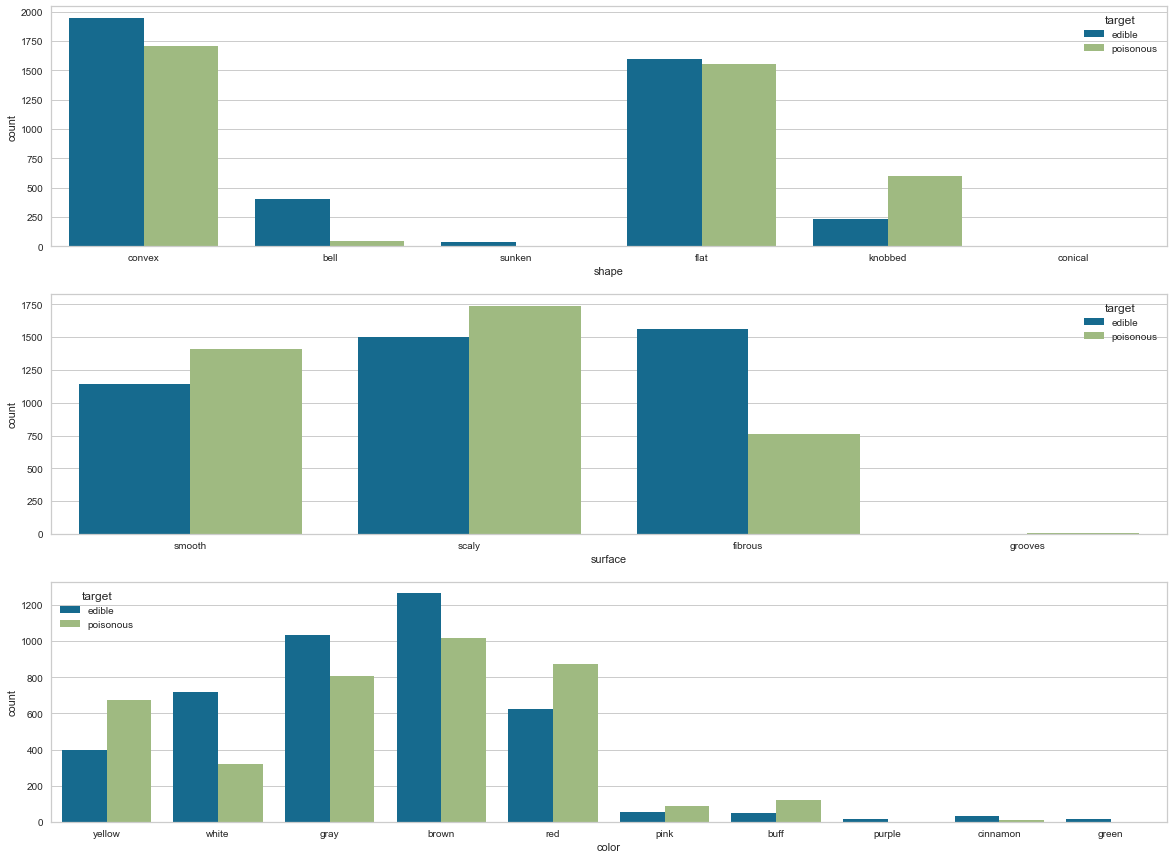

In [207]:
# TODO: add countplots for each feature.
fig, pl = plt.subplots(3,1, figsize = (20,15))
sns.countplot(data['shape'],hue = data['target'],ax =pl[0])
sns.countplot(data['surface'],hue = data['target'],ax =pl[1])
sns.countplot(data['color'],hue = data['target'],ax =pl[2])


### 2.2 Class (im)balance
Use `value_counts()` on the target vector `y` to report the number of samples in each class to check class imbalance.

In [211]:
# TODO: add value_counts() here
y.value_counts()

edible       4208
poisonous    3915
Name: target, dtype: int64

### *Question 2:* Previously, a class ratio of 2:1 or higher between classes was used as an indication of class imbalance. Given the values above, is there class imbalance here and do train-test splits need to be stratified?

*According to my assumption the classes have almost simialr number of samples hence stratifying is not necesary*


## 3. Preprocessing
In this dataset, all features are discrete and nominal and need to be encoded. You will use a `OneHotEncoder`.

The target vector is discrete and nominal as well. While sklearn is OK using string labels, you will use a `LabelEncoder` to convert strings to integers and keep the encoder to translate between the two representations.

### 3.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a varible `X_enc`. Use `spares=False`, as `GaussianNB()` classifier used later requires a dense matrix. Print shape of `X_enc`.

In [212]:
# TODO: add OneHotEncoder here
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
X_enc = ohe.fit_transform(X)
print(X_enc.shape)

(8123, 20)


### *Question 3:* How many features are there in the feature matrix `X_enc`?

*20 features*


### 3.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a varibale `y_enc`.

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object.

In [213]:
# TODO: add LabelEncoder here
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(y_enc)
print(le.classes_)

[0 0 1 ... 0 1 0]
['edible' 'poisonous']


### *Question 4:* How are class label strings mapped to integers? Show an example for both.
Hint: use `transform()` or `inverse_transform()` method of the `LabelEncoder` object.

*It encodes label strings or target vectors into numbers betwwon 0 and n_classes-1 *


eg 
trans = le.transform(y)

## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets.

In [214]:
# TODO: add train_test_split() here
from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(X_enc, y_enc, random_state = 37, 
                                                    test_size = 0.2 )

## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `GaussianNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [215]:
# TODO: add cross-validation comparison here
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier




models = [LogisticRegression(max_iter=10000), SVC(), GaussianNB(), RandomForestClassifier(), GradientBoostingClassifier()]
for model in models:
    print('{} | {}'.format(model.__class__.__name__,get_classifier_cv_score(model, X_train, Y_train, scoring = 'average_precision')))
    










LogisticRegression | train_score =  0.661     test_score =  0.658     
SVC | train_score =  0.710     test_score =  0.699     
GaussianNB | train_score =  0.661     test_score =  0.661     
RandomForestClassifier | train_score =  0.806     test_score =  0.792     
GradientBoostingClassifier | train_score =  0.793     test_score =  0.788     


## 6. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Support vector machine classifier might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [300, 500, 700, 1000]`
- `'max_depth': [7, 9, 11, 13]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [ ]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [300, 500, 700, 1000],
             'max_depth': [7, 9, 11, 13]}


grid = GridSearchCV(RandomForestClassifier(random_state=55), param_grid, cv=7,n_jobs=-1, scoring = 'average_precision',return_train_score=True)

In [ ]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train, Y_train)

In [ ]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)

In [ ]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid)

### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [231]:
# TODO: Setup grid search for GradientBoostingClassifier(max_depth=5, random_state=56)
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200],
             'learning_rate': [0.001, 0.01, 0.1, 1.0]}


grid = GridSearchCV(GradientBoostingClassifier(max_depth=5, random_state=56), param_grid, cv=7,n_jobs=-1, scoring = 'average_precision',return_train_score=True)

In [232]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train, Y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [233]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)

Best parameters = {'learning_rate': 0.1, 'n_estimators': 100}
Train score 0.806
Validation score 0.795


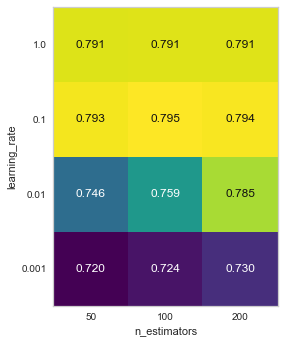

In [234]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid)

### 6.3 SVC grid search
Perform grid search using `GridSearchCV` for the `SVC()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'C': [0.0001, 0.001, 0.01, 0.1]`
- `'gamma': [0.1, 1, 10, 100]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [235]:
# TODO: Setup grid search for SVC()
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1],
             'gamma': [0.1, 1, 10, 100]}


grid = GridSearchCV(SVC(), param_grid, cv=7,n_jobs=-1, scoring = 'average_precision',return_train_score=True)

In [236]:
# TODO: perform the grid search by calling fit()
grid.fit(X_train, Y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [237]:
# TODO: call print_grid_search_result() to print the results
print_grid_search_result(grid)

Best parameters = {'C': 0.0001, 'gamma': 10}
Train score 0.779
Validation score 0.772


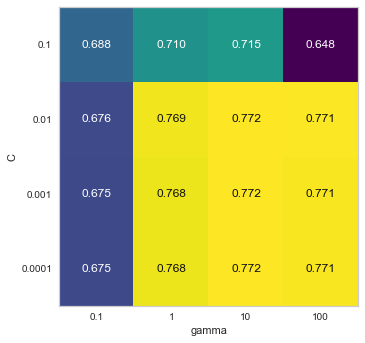

In [238]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid)

### *Question 5:* What are the training and validation scores of the three tuned (best) models? Summarize the results here.

*YOUR ANSWER HERE*


## 7. Best model: Find a better threshold

### 7.1 Precision and recall curve

From the results above, it looks like `RandomForestClassifier()` performs well.

Using the training dataset and best `RandomForestClassifier()` from the grid search above:
1. Calculate predicted probabilities using `cross_val_predict()` with parameters `cv=7, method='predict_proba'`.
2. Plot the precision-recall curve indicating where the default threshold 0.5 lies (see lecture notebook for an example).

Include a legend and axis labels.


In [246]:
#TODO: Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')
model = RandomForestClassifier(max_depth= 11, 
                               n_estimators= 700, 
                               random_state=55)

model.fit(X_train, Y_train)

y_pred = cross_val_predict(model, X_train, Y_train,cv=7, method = 'predict_proba')

Text(0.5, 1.0, 'Precision Recall Curve')

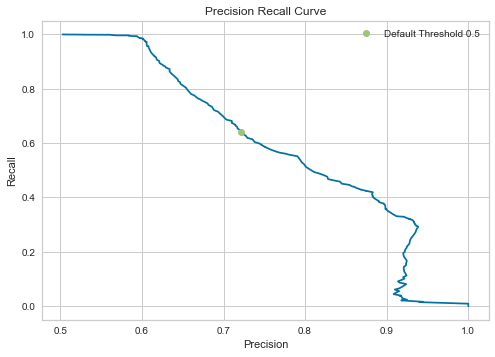

In [247]:
#TODO: Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(Y_train, y_pred[:,1])

plt.plot(precision, recall)

index = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[index], recall[index], 'o', label = "Default Threshold 0.5")

plt.legend()
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")

### 7.2 Find a better threshold
It is important in this application to achieve high recall. Determine the probability threshold to achieve recall higher than 0.999. Store this threshold in a variable and print it.

In [248]:
#TODO: Find and print threshold for recall>0.999
index = 0
for i in recall:
    if i < .999:
        print(index)
        break;
    index = index + 1
    
index = np.argwhere(recall > 0.999)[-1]

min_thresh = thresholds[index]

print(min_thresh)

38
[0.01912227]


## 8. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset.

In [249]:
#TDOD: Retrain random forest classifier
model = RandomForestClassifier(max_depth= 11, n_estimators= 700, random_state=55)
model = grid.best_estimator_
model.fit(X_train, Y_train)

SVC(C=0.0001, gamma=10)

## 9. Evaluate on test data

Using the retrained model and the test dataset:
- print the classification report
- plot the confusion matrix using plot_confusion_matrix()

Make sure the plot has class labels and a title.

Repeat these steps for the default threshold and the optimal threshold determined in step 7.

### 9.1 Evaluation with default threshold

In [250]:
#TODO: print classification report using default threshold
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       843
           1       0.00      0.00      0.00       782

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625



C:\Users\rahia\miniconda3\envs\ensf-ml\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [253]:
#TODO: call plot_confusion_matrix()
# plot_confusion_matrix(y_test, model.predict(x_test), 'Default Threshold')

### 9.2 Evaluation with new threshold form Step 7.

In [252]:
#TODO: print classification report using default threshold
# i = np.argwhere(recall > 0.999)[-1]
# threshold = thresholds[i]

# new = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)

# print(classification_report(y_test, new))

AttributeError: predict_proba is not available when  probability=False

In [ ]:
#TODO: call plot_confusion_matrix()


### *Question 6:* What are the precision, recall and accuracy on the test set using the default and optimal thresholds of the best (tuned) random forest model?

*The default threshold contains a precision of .69, recall of .63 and an accuracy of 70

THe optimised threshold contains a recall of 1 and accuracy of .49*


### *Question 7:* How many false negatives does the model produce on the test set with the default and optimal thresholds of the best (tuned) random forest model.?

*The default threshold produced------- false negatives, while the optimised one produces zero*



## 10. Conclusion

In conclusion, comment on the following items:
- In the classification of edible vs poisonous mushrooms, why is high recall desired?
- In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions mean and what are the consequences of making these mistakes?
- Is the fine-tuned model with new threshold satisfactory, i.e. a useful model for the task, or is more work needed? Explain.

the recall needs to be high as even a slight mistake will result in someone dying after eating the mushroom is eaten. 


A false positive means that the mushroom was incorrectly diagnosed as poisonous versus a false negative means that a poinsonous mushroom was diagnosed as edible which could result in death or sickness if eaten.




## Reflection

*I had very little time to do this lab hence I couldnt do my own research however, it helped to clear out a lot of my confusion that I had while following the lectures.*

